In [13]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid

In [2]:
HEIGHT = 320
WIDTH = 200

In [3]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2LAB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]
            imgs = [np.uint8(img) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs

#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [4]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(np.array(pic), dsize=self.size, interpolation=cv2.INTER_BITS)


In [5]:
tf = transforms.Compose({
    OpenCVResize(size=(WIDTH, HEIGHT)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
})

gray_dataset = ImageDataset(path='C:/Users/Sachith/Desktop/dataset/faces/grayscale', transform=tf, code=cv2.COLOR_BGR2GRAY)
rgb_dataset = ImageDataset(path='C:/Users/Sachith/Desktop/dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2RGB)
lab_dataset = ImageDataset(path='C:/Users/Sachith/Desktop/dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2LAB)

In [6]:
torch.manual_seed(101)

is_cuda = torch.cuda.is_available()

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=10, shuffle=True, pin_memory=is_cuda)
rgb_data_loader = DataLoader(dataset=rgb_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda)
# LAB IMAGES FOR VISUALIZATION AND TRAINING PURPOSE.
lab_data_loader = DataLoader(dataset=lab_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda)
l_data_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=10, shuffle=False, pin_memory=is_cuda)
ab_data_loader = DataLoader(dataset=lab_dataset.ab_images(), batch_size=10, shuffle=False ,pin_memory=is_cuda)

#### View a single batch grayscale and colored image sample.

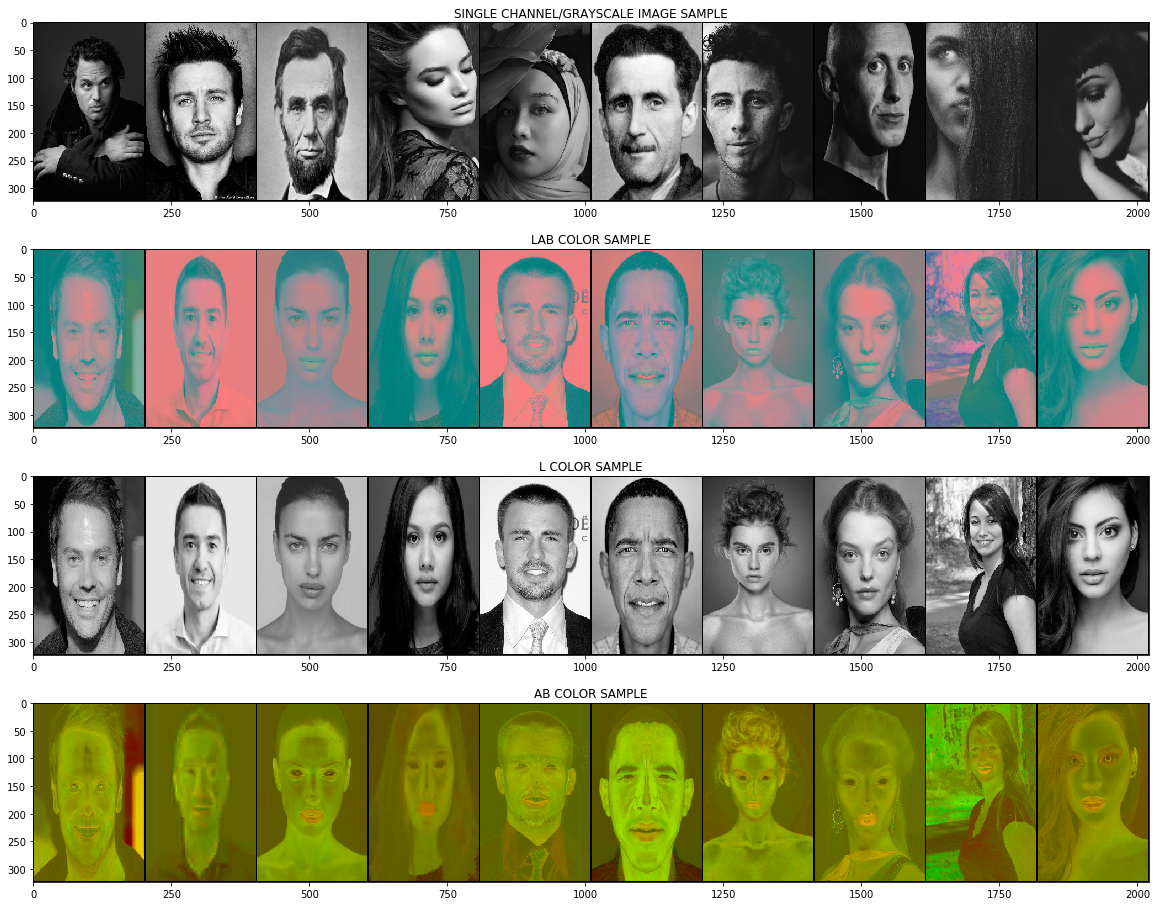

In [7]:
g_ims, l_ims, ab_ims, lab_ims, rgb_ims = (None, None, None, None, None)
for g_ims in gray_data_loader:
    break

for l_ims in l_data_loader:
    break

for ab_ims in ab_data_loader:
    break

for lab_ims in lab_data_loader:
    break

for rgb_ims in rgb_data_loader:
    break

plt.figure(figsize=(20,16))

im = make_grid(g_ims, nrow=10, normalize=True)

plt.subplot(411)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(lab_ims, nrow=10, normalize=True)

plt.subplot(412)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("LAB COLOR SAMPLE")

im = make_grid(l_ims, nrow=10, normalize=True)

plt.subplot(413)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title("L COLOR SAMPLE")

im = make_grid(ab_ims, nrow=10, normalize=True)
im = np.stack([im[0], im[1], np.zeros((im.shape[1], im.shape[2]))])

plt.subplot(414)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title('AB COLOR SAMPLE')

plt.show()

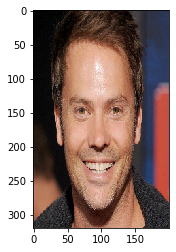

In [9]:
lab = np.stack([l_ims[0][0], ab_ims[0, 0], ab_ims[0, 1]], axis=0)
stack = lab * 255

stack = np.transpose(stack, (1, 2, 0)).astype(np.uint8)
stack = cv2.cvtColor(stack, code=cv2.COLOR_LAB2RGB)

plt.imshow(stack)

In [10]:
device = torch.device('cuda' if is_cuda else 'cpu')
device

device(type='cpu')

####  Convolutional Neural Network Model

In [89]:
class RGBNet(nn.Module):

    def __init__(self, in_features=1, out_features=2, n_layers=(128, 32, 8)):
        super().__init__()
        # Two layer configurations to sandwich resnet layers.
        self.in_features = in_features
        self.out_features = out_features
        self.n_layers = n_layers
        # RESNET-18 number of input and output features.
        self.resnet_in = 3
        self.resnet_out = 512

        self.dilate_sequence = self.dilate_layer()
        self.resnet = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2])
        self.localize_sequence = self.localize_layer()

    def dilate_layer(self):
        return nn.Sequential(nn.Conv2d(in_channels=self.in_features,
                                       out_channels=self.resnet_in,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1),
                             nn.BatchNorm2d(self.resnet_in),
                             nn.ReLU())

    def localize_layer(self):
        layers, n_in = [], self.resnet_out

        for nl in self.n_layers:
            layers.append(nn.Conv2d(in_channels=n_in,
                                    out_channels=nl,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1))
            layers.append(nn.BatchNorm2d(nl))
            layers.append(nn.ReLU())
            layers.append(nn.Upsample(scale_factor=3.))

            n_in = nl

        layers.append(nn.Conv2d(in_channels=n_in,
                                out_channels=self.out_features,
                                kernel_size=3,
                                stride=1, padding=1))

        return nn.Sequential(*layers)

    def forward(self, X):
        print(X.shape)
        X = self.dilate_sequence(X)
        print(X.shape)
        X = self.resnet(X)
        print(X.shape)
        return self.localize_sequence(X)


model = RGBNet()

if is_cuda:
  model = model.cuda()
model

RGBNet(
  (dilate_sequence): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )


In [88]:
with torch.no_grad():

    model.eval()

    s = model(l_ims[0].to(device).view(-1, 1, HEIGHT, WIDTH))
    print(s.shape)

# s = torch.stack([l_ims[0][0], s[0, 0].cpu(), s[0, 1].cpu()]) * 255
# s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
# s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

torch.Size([1, 1, 320, 200])
torch.Size([1, 3, 320, 200])
torch.Size([1, 512, 10, 7])
torch.Size([1, 2, 270, 189])


In [ ]:
count = 0
for params in model.parameters():
  count += params.numel()

count

#### Training Neural Network Models

In [76]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [77]:
epoch = 5
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    batch_time = time.time()

    for batch, (X, y) in enumerate(zip(l_data_loader, ab_data_loader)):
        batch += 1

        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)

        losses.append(loss)

        if batch % 5 == 0 or batch == 1:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

torch.Size([10, 1, 320, 200])
torch.Size([10, 3, 320, 200])
torch.Size([10, 512, 10, 7])


C:\Users\Sachith\anaconda3\envs\pytorchdev\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([10, 2, 320, 200])) that is different to the input size (torch.Size([10, 2, 640, 448])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (448) must match the size of tensor b (200) at non-singleton dimension 3

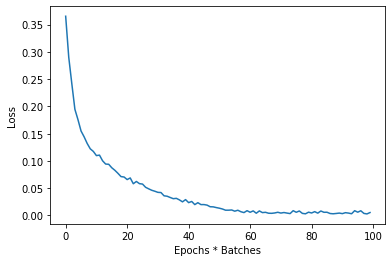

In [42]:
plt.plot(losses)
plt.xlabel('Epochs * Batches')
plt.ylabel('Loss')

del losses

#### Validate images with same dataset used to train.

In [43]:
@torch.no_grad()
def validate(img):

    model.eval()

    ab = model(img.to(device))

    lab = np.stack([img[0, 0], ab.cpu()[0, 0], ab.cpu()[0, 1]], axis=0) * 255

    lab = np.transpose(lab, axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    plt.imshow(lab)

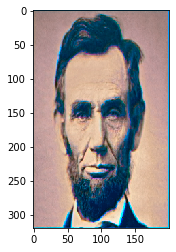

In [44]:
validate(g_ims[2].view(-1, 1, HEIGHT, WIDTH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3529) tensor(-0.7882)


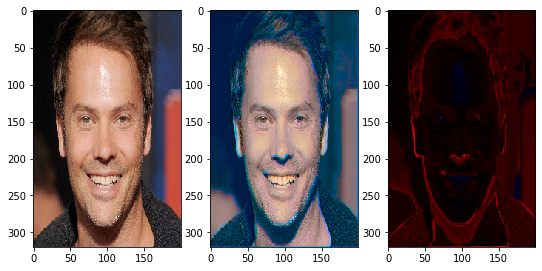

In [45]:
IMG_INDEX = 0

with torch.no_grad():

    model.eval()

    plt.figure(figsize=(9, 8))
    plt.subplot(131)
    plt.imshow(np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0)))

    s = model(l_ims[IMG_INDEX].to(device).view(-1, 1, HEIGHT, WIDTH))
    s = torch.stack([l_ims[IMG_INDEX][0], s[0, 0].cpu(), s[0, 1].cpu()]) * 255
    s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
    s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

    plt.subplot(132)
    plt.imshow(s)

    org = np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0))
    pred = torch.Tensor(s) / 255

    diff = torch.sub(input=org, other=pred)

    print(diff[:, :, 2].max(), diff[:, :, 2].min())

    plt.subplot(133)
    plt.imshow(diff)